This first sell below are installing and testing the packages

In [1]:
import torch
print("PyTorch version:", torch.__version__)

import torchaudio
print("torchaudio version:", torchaudio.__version__)

import librosa
print("Librosa version:", librosa.__version__)

import numpy as np
print("NumPy version:", np.__version__)

import pandas as pd
print("Pandas version:", pd.__version__)

import matplotlib
print("Matplotlib version:", matplotlib.__version__)

import scipy
print("SciPy version:", scipy.__version__)


PyTorch version: 2.2.2
torchaudio version: 2.2.2
Librosa version: 0.10.2.post1
NumPy version: 1.26.4
Pandas version: 2.2.3
Matplotlib version: 3.9.2
SciPy version: 1.12.0


Skeleton Code

Data Loading & Preprocessing:
The function load_audio_compute_spectrogram uses Librosa to load an audio file and compute its STFT. It then extracts the magnitude (i.e., the absolute value) and normalizes it.

Model Definition:
The AudioAutoencoder is a simple convolutional autoencoder. The encoder compresses the input spectrogram to a lower-dimensional representation; the decoder attempts to reconstruct the original spectrogram from this representation.

Training Loop:
The train_model function provides a basic loop where each batch (here, for simplicity, a list of identical tensors) is passed through the model. The loss (MSE) is computed between the input and the output, and the model parameters are updated using the Adam optimizer.

Inference, Visualization, & Reconstruction:
After training, the model is used to reconstruct the input spectrogram.
Both the original and reconstructed spectrograms are displayed side-by-side using Matplotlib and Librosa’s display functions.
Finally, the Griffin–Lim algorithm is used to reconstruct an audio waveform from the (reconstructed) magnitude spectrogram, and the result is saved to disk with SoundFile.

Epoch 1/5, Loss: 0.211992
Epoch 2/5, Loss: 0.197416
Epoch 3/5, Loss: 0.175717
Epoch 4/5, Loss: 0.143307
Epoch 5/5, Loss: 0.103131


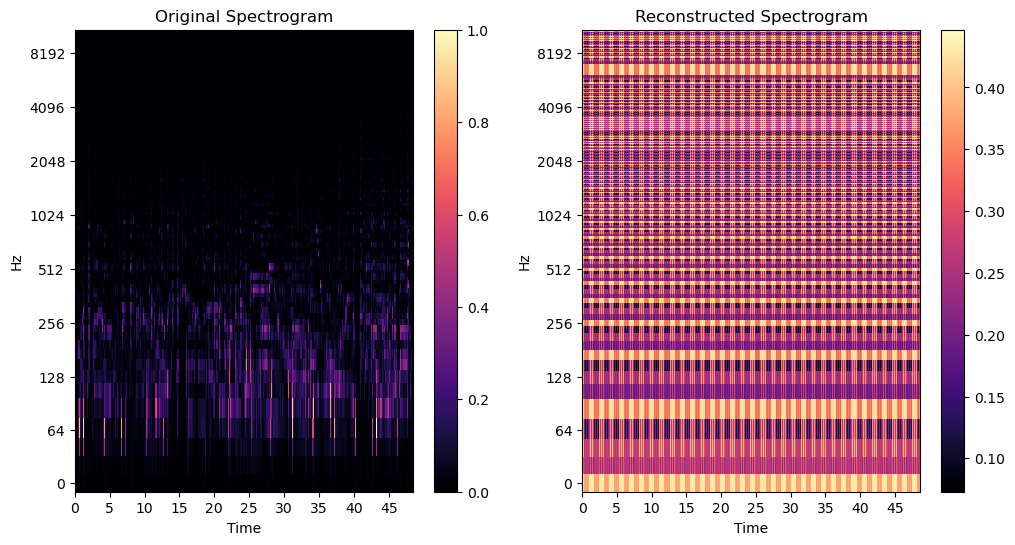

Reconstructed audio saved to reconstructed_output.wav


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.optim as optim
import soundfile as sf

#Loading an audio file and computing magnitude spectrogram
#Need to return a loaded audio signal (np.ndarray), 
#a normalized magnitude spectrogram (np.ndarray), and a sample rate (int)
def load_audio_compute_spectrogram(file_path, sr=22050, n_fft=1024, hop_length=512):	
	audio, sr = librosa.load(file_path, sr=sr)

	#Short time fourier transform maps signal into 2-d function of t and freq
	stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

	magnitude = np.abs(stft)
	magnitude = magnitude / np.max(magnitude)
	return audio, magnitude, sr

#Simple NN Model
class AudioAutoEncoder(nn.Module):
	def __init__(self):
		super(AudioAutoEncoder, self).__init__()
		
		#Two convolutional layers reduce spatial dimensions
		self.encoder = nn.Sequential(
			nn.Conv2d(1, 16, kernel_size=1, stride=2, padding=1), #Output (batch, 16, H/2, W/2)
			nn.ReLU(),
			nn.Conv2d(16, 32, kernel_size=1, stride=2, padding=1), #Output (batch, 32, H/4, W/4)
			nn.ReLU()
		)

		#Two transposed Convolution restore OG dimensions
		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
			nn.ReLU(),
			nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
			nn.Sigmoid() #Quick check on outputs between 0 and 1
		)
	def forward(self, x):
		encoded=self.encoder(x)
		decoded=self.decoder(encoded)
		return decoded

#Skeleton for training loop
def train_model(model, data, epochs=10, lr=1e-3):

	model.train()
	optimizer = optim.Adam(model.parameters(), lr=lr)
	criterion = nn.MSELoss() #Mean Squared Error loss for reconstruction

	for epoch in range(epochs):
		epoch_loss = 0.0
		for batch in data:
			optimizer.zero_grad()
			output = model(batch)
			if output.shape!= batch.shape:
				target_h, target_w = batch.shape[2], batch.shape[3] #Cropping output if there's a mismatch
				output = output[:, :, :target_h, :target_w]
			loss = criterion(output, batch)
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()
		print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data):.6f}")
	return model

#Main Routine to load data, train, and inference
if __name__=="__main__":
	file_path = 'file.wav'
	audio, spectrogram, sr = load_audio_compute_spectrogram(file_path)#Loading audio and spectrogram

	#Convert spectro->PyTorch tensor; +batch and channel dimensions
	spectrogram_tensor = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0) 
	model=AudioAutoEncoder()
	dataset = [spectrogram_tensor for _ in range(10)] #Practice by replicating same sample 10 times
	
	#Training the model
	model = train_model(model, dataset, epochs=5, lr=1e-3)

	#Switching to eval mode & perform inference
	model.eval()
	with torch.no_grad():
		reconstructed = model(spectrogram_tensor)

	reconstructed_np = reconstructed.squeeze().numpy() #removing xtra dim, conv back to Numpy for visualization

	#Showing the before and after spectrograms
	plt.figure(figsize=(12,6))
	plt.subplot(1,2,1)
	librosa.display.specshow(spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='log')
	plt.title('Original Spectrogram')
	plt.colorbar()

	plt.subplot(1,2,2)
	librosa.display.specshow(reconstructed_np, sr=sr, hop_length=512, x_axis='time', y_axis='log')
	plt.title('Reconstructed Spectrogram')
	plt.colorbar()
	plt.show()

	#Griffin Lim method reconstructs audio from spectrogram 
	reconstructed_audio = librosa.griffinlim(reconstructed_np, n_iter=32, hop_length=512, win_length=1024)

	output_path = 'reconstructed_output.wav'
	sf.write(output_path, reconstructed_audio, sr)
	print(f"Reconstructed audio saved to {output_path}")


Next Steps:

Expand the Data Pipeline: Replace the dummy dataset with a proper DataLoader that reads and preprocesses your collection of raw multitracks.

Model Improvements: Experiment with deeper architectures or incorporate additional techniques (e.g., GANs or perceptual loss functions) as you refine your approach.

Integration with Logic Pro: Once you have reliable outputs, you can export high-quality WAV files to import into Logic Pro for further manual evaluation and mixing.

Documentation & Evaluation: Record your code modifications, training experiments, and evaluation metrics as you move toward your thesis paper and eventual IEEE submission.